#Right click to open this notebook in Colab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mettinger/mixModel/blob/main/mixModelTest.ipynb)

# The statistical model:

$mode_i \sim$ MultivariateNormal(modeMean, modeCovariance) for $i = 1,...,$nModesPerPerson    

$location_{ij} \sim$ MultivariateNormal($mode_i$, personCovariance) for $i = 1,...,$nModesPerPerson and $j = 1,...,$nPerson 

$data_{ijk} \sim$ MultivariateNormal($location_{ij}$, dataCovariance) for $i = 1,...,$nModesPerPerson and $j = 1,...,$nPerson and $k = 1,...,$nSamplesPerLocationPerPerson


Notes:  

1.  nModesPerPerson, nPerson, nSamplesPerLocationPerPerson are constants specified below.  One further specified constant is dataDimension which specifies the dimension of the data.
2.  modeMean, modeCovariance, personCovariance, dataCovariance are statistical parameters specificed below and used in the data generating function.    
3.  The goal of inference is to "discover" the parameters $mode_i$ and $location_{ij}$ for all i,j.  
4.  The parameters in item #2 above are assumed "known" and used in the model.

# Install Pyro and do imports.

In [1]:
!pip3 install pyro-ppl 

In [2]:
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoGuideList, AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal, AutoDiscreteParallel 
from pyro.infer.autoguide import init_to_mean, init_to_uniform
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS

from torch.distributions import constraints
import torch
import numpy as np
from matplotlib import pyplot
import pandas as pd

pyro.enable_validation(True)


# Instantiate parameters

In [3]:
nPerson = 5
nModesPerPerson = 3
dataDimension = 2 # i.e. the dimensionality of the samples
nSamplesPerLocationPerPerson = 10

# scaling factors for diagonal covariance matrices
modeCovarianceFactor = 100
personCovarianceFactor = 1
dataCovarianceFactor = .01

modeMean = torch.zeros(dataDimension)
modeCovariance = modeCovarianceFactor * torch.eye(dataDimension)
personCovariance = personCovarianceFactor * torch.eye(dataDimension)
dataCovariance = dataCovarianceFactor * torch.eye(dataDimension)

# Function for generating data

In [4]:
def generateData(nPerson, nModesPerPerson, dataDimension, nSamplesPerLocationPerPerson):
    modeLocs = {}
    locs = {}
    data = []
    personIndex = []
    
    for thisMode in pyro.plate("modeLoc_loop", nModesPerPerson):
        modeLocName = "modeLoc_{}".format(thisMode)
        thisModeLoc = pyro.sample(modeLocName, dist.MultivariateNormal(modeMean, modeCovariance))
        modeLocs[modeLocName] = thisModeLoc
        
        for thisPerson in pyro.plate("person_loop", nPerson):
            locName = "locModePerson_{}{}".format(thisMode, thisPerson)
            thisLoc = pyro.sample(locName, dist.MultivariateNormal(thisModeLoc, personCovariance))
            locs[locName] = thisLoc

            for thisDataSample in pyro.plate("data_loop", nSamplesPerLocationPerPerson):
                dataName = "dataMPS_{}{}{}".format(thisMode, thisPerson, thisDataSample)
                thisDatum = pyro.sample(dataName, dist.MultivariateNormal(thisLoc, dataCovariance)).numpy()
                data.append(thisDatum)
                personIndex.append(thisPerson)
    
    return modeLocs, locs, np.hstack((np.expand_dims(np.array(personIndex).transpose(),1), np.array(data)))

# Generate simulated data

In [5]:
#pyro.set_rng_seed(1)
pyro.clear_param_store()
modeLocsTrue, locsTrue, data = generateData(nPerson, nModesPerPerson, dataDimension, nSamplesPerLocationPerPerson)

# Print the paramters and plot the simulated data

{'modeLoc_0': tensor([-4.4534, -7.1675]), 'modeLoc_1': tensor([  0.8725, -14.0480]), 'modeLoc_2': tensor([  6.5940, -15.3650])}

{'locModePerson_00': tensor([-7.5905, -7.5867]), 'locModePerson_01': tensor([-3.9469, -6.6749]), 'locModePerson_02': tensor([-3.0652, -6.7982]), 'locModePerson_03': tensor([-3.2510, -6.3673]), 'locModePerson_04': tensor([-3.9291, -6.6791]), 'locModePerson_10': tensor([ -1.7507, -13.4490]), 'locModePerson_11': tensor([  1.6860, -14.4084]), 'locModePerson_12': tensor([  0.8446, -14.2909]), 'locModePerson_13': tensor([  0.3803, -15.0920]), 'locModePerson_14': tensor([  0.2833, -13.9706]), 'locModePerson_20': tensor([  5.8934, -13.3425]), 'locModePerson_21': tensor([  8.4521, -14.2347]), 'locModePerson_22': tensor([  5.9764, -14.7310]), 'locModePerson_23': tensor([  6.3558, -16.0849]), 'locModePerson_24': tensor([  5.8642, -15.7302])}


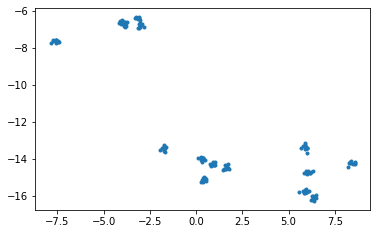

In [6]:
person = torch.tensor(np.cast['int'](data[:,0]))
samples = torch.tensor(data[:,1:]).float()
print(modeLocsTrue)
print()
print(locsTrue)

fig = pyplot.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
pyplot.plot(data[:,1], data[:,2],'.')

# Define the model

In [7]:
@config_enumerate
def model(person, sample):
    
    loc = torch.zeros(size=(nModesPerPerson, nPerson, dataDimension))
    
    for thisMode in range(nModesPerPerson):
        modeLocName = "modeLoc_{}".format(thisMode)
        thisModeLoc = pyro.sample(modeLocName, dist.MultivariateNormal(modeMean, modeCovariance))
        
        for thisPerson in range(nPerson):
            locName = "locModePerson_{}{}".format(thisMode, thisPerson)
            thisLoc = pyro.sample(locName, dist.MultivariateNormal(thisModeLoc, personCovariance))

            loc[thisMode, thisPerson, :] = thisLoc.clone()
    
    with pyro.plate('data_loop', len(person)):
        modeAssignment = pyro.sample('modeAssignment', 
                                     dist.Categorical((1./nModesPerPerson) * torch.ones(nModesPerPerson)))
        
        pyro.sample('obs', 
                    dist.MultivariateNormal(loc[modeAssignment, person, :], dataCovariance), 
                    obs=sample)

#Choose the guide

In [8]:
guideChoice = 2
initErrorScale = 1

def initValues(site):

  trueValues = {**modeLocsTrue,**locsTrue}
  error = initErrorScale * torch.rand(size=[2])
  initValue = trueValues[site['name']] + error
  print (site['name'], error, initValue)
  return initValue

if guideChoice == 0:
  guide = AutoGuideList(model)
  guide.append(AutoDelta(poutine.block(model, hide=['modeAssignment']), init_loc_fn=initValues))
  guide.append(AutoDiscreteParallel(poutine.block(model, expose=["modeAssignment"])))

elif guideChoice == 1:
  guide = AutoGuideList(model)
  guide.append(AutoDiagonalNormal(poutine.block(model, hide=['modeAssignment']), init_loc_fn=initValues))
  guide.append(AutoDiscreteParallel(poutine.block(model, expose=["modeAssignment"])))

elif guideChoice == 2:
  @config_enumerate
  def guide(person, sample):

          modeLocMean = torch.zeros(size=(nModesPerPerson, dataDimension))
          modeLoc = torch.zeros(size=(nModesPerPerson, dataDimension))

          locModePersonMean = torch.zeros(size=(nModesPerPerson, nPerson, dataDimension))
          locModePerson = torch.zeros(size=(nModesPerPerson, nPerson, dataDimension))

          for thisMode in range(nModesPerPerson):
              
              modeLocName = "modeLoc_{}".format(thisMode)
              modeLocMean[thisMode,:] = pyro.param('a{}'.format(thisMode), modeLocsTrue[modeLocName].clone())
              modeLoc[thisMode,:] = pyro.sample(modeLocName, 
                                                dist.MultivariateNormal(modeLocMean[thisMode,:], torch.eye(dataDimension)))
          
              for thisPerson in range(nPerson):
                  
                  locName = "locModePerson_{}{}".format(thisMode, thisPerson)
                  locModePersonMean[thisMode, thisPerson, :] = pyro.param('b{}{}'.format(thisMode,thisPerson), locsTrue[locName].clone())
                  locModePerson[thisMode, thisPerson,:] = pyro.sample('locModePerson_{}{}'.format(thisMode, thisPerson), 
                                                                      dist.MultivariateNormal(locModePersonMean[thisMode, thisPerson, :], torch.eye(dataDimension)))

          with pyro.plate('data_loop', len(person)):
              modeAssignment = pyro.sample("modeAssignment", dist.Categorical((1./nModesPerPerson) * torch.ones(nModesPerPerson)))

# Do SVI

In [9]:
pyro.clear_param_store()

optim = pyro.optim.Adam({'lr': 0.05})
elbo = TraceEnum_ELBO()
svi = SVI(model, guide, optim, loss=elbo)

num_iters = 10000 
losses = []

for i in range(num_iters):
    loss = svi.step(person, samples)
    losses.append(loss)
    if i % 1000 == 0:
        print("Elbo loss: {}".format(loss))

Elbo loss: 514373.6875
Elbo loss: 273068.0625
Elbo loss: 263871.15625
Elbo loss: 269829.40625
Elbo loss: 268272.84375
Elbo loss: 271362.90625
Elbo loss: 280761.3125
Elbo loss: 271878.96875
Elbo loss: 270648.40625
Elbo loss: 265805.03125


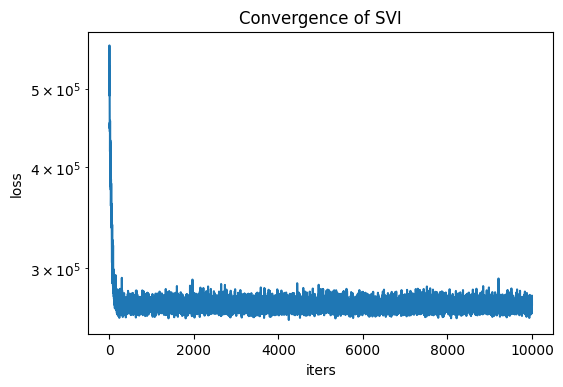

In [10]:
pyplot.figure(dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

# Are the parameter estimates close to the ground truth?

In [11]:
print(modeLocsTrue)
print()
print(locsTrue)

{'modeLoc_0': tensor([-4.4534, -7.1675]), 'modeLoc_1': tensor([  0.8725, -14.0480]), 'modeLoc_2': tensor([  6.5940, -15.3650])}

{'locModePerson_00': tensor([-7.5905, -7.5867]), 'locModePerson_01': tensor([-3.9469, -6.6749]), 'locModePerson_02': tensor([-3.0652, -6.7982]), 'locModePerson_03': tensor([-3.2510, -6.3673]), 'locModePerson_04': tensor([-3.9291, -6.6791]), 'locModePerson_10': tensor([ -1.7507, -13.4490]), 'locModePerson_11': tensor([  1.6860, -14.4084]), 'locModePerson_12': tensor([  0.8446, -14.2909]), 'locModePerson_13': tensor([  0.3803, -15.0920]), 'locModePerson_14': tensor([  0.2833, -13.9706]), 'locModePerson_20': tensor([  5.8934, -13.3425]), 'locModePerson_21': tensor([  8.4521, -14.2347]), 'locModePerson_22': tensor([  5.9764, -14.7310]), 'locModePerson_23': tensor([  6.3558, -16.0849]), 'locModePerson_24': tensor([  5.8642, -15.7302])}


In [12]:
list(pyro.get_param_store().items())

[('a0', tensor([  0.7457, -11.8564], requires_grad=True)),
 ('b00', tensor([ -0.9356, -11.3597], requires_grad=True)),
 ('b01', tensor([  2.0522, -11.7329], requires_grad=True)),
 ('b02', tensor([  1.2202, -11.9416], requires_grad=True)),
 ('b03', tensor([  1.1045, -12.5555], requires_grad=True)),
 ('b04', tensor([  0.9486, -12.1401], requires_grad=True)),
 ('a1', tensor([  0.7095, -12.3037], requires_grad=True)),
 ('b10', tensor([ -1.0997, -11.3950], requires_grad=True)),
 ('b11', tensor([  1.9287, -11.5610], requires_grad=True)),
 ('b12', tensor([  1.6198, -11.8076], requires_grad=True)),
 ('b13', tensor([  1.1474, -12.3826], requires_grad=True)),
 ('b14', tensor([  0.8051, -12.0190], requires_grad=True)),
 ('a2', tensor([  0.5530, -11.9222], requires_grad=True)),
 ('b20', tensor([ -0.9358, -11.2253], requires_grad=True)),
 ('b21', tensor([  2.0010, -11.8219], requires_grad=True)),
 ('b22', tensor([  1.5597, -12.3021], requires_grad=True)),
 ('b23', tensor([  1.1317, -12.5508], requi

In [13]:
from pyro.infer import Predictive

num_samples = 5
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.detach().cpu().numpy() for k, v in predictive(person, samples).items() if k != "obs"}
svi_samples

{'locModePerson_00': array([[[ -1.0650727, -10.084209 ]],
 
        [[ -1.0109394, -11.036551 ]],
 
        [[ -2.0639813, -10.458916 ]],
 
        [[  1.7947853, -11.276602 ]],
 
        [[ -1.1268907, -12.945353 ]]], dtype=float32),
 'locModePerson_01': array([[[  2.737119 , -12.908292 ]],
 
        [[  2.3563251, -12.29699  ]],
 
        [[  3.4556978, -11.64302  ]],
 
        [[  2.7134867, -12.571478 ]],
 
        [[  1.7879333, -11.443526 ]]], dtype=float32),
 'locModePerson_02': array([[[  1.1943836 , -12.869235  ]],
 
        [[  1.172535  , -13.352017  ]],
 
        [[  0.81210077, -12.5049925 ]],
 
        [[  2.084793  , -13.363188  ]],
 
        [[ -0.08627641, -13.54209   ]]], dtype=float32),
 'locModePerson_03': array([[[  1.7246647 , -13.428793  ]],
 
        [[  1.0251964 , -12.555632  ]],
 
        [[  1.31438   , -11.049241  ]],
 
        [[  0.02164698, -12.094969  ]],
 
        [[ -0.37742877, -12.057601  ]]], dtype=float32),
 'locModePerson_04': array([[[  1.209353

In [14]:
print(modeLocsTrue)
print()
print(locsTrue)

{'modeLoc_0': tensor([-4.4534, -7.1675]), 'modeLoc_1': tensor([  0.8725, -14.0480]), 'modeLoc_2': tensor([  6.5940, -15.3650])}

{'locModePerson_00': tensor([-7.5905, -7.5867]), 'locModePerson_01': tensor([-3.9469, -6.6749]), 'locModePerson_02': tensor([-3.0652, -6.7982]), 'locModePerson_03': tensor([-3.2510, -6.3673]), 'locModePerson_04': tensor([-3.9291, -6.6791]), 'locModePerson_10': tensor([ -1.7507, -13.4490]), 'locModePerson_11': tensor([  1.6860, -14.4084]), 'locModePerson_12': tensor([  0.8446, -14.2909]), 'locModePerson_13': tensor([  0.3803, -15.0920]), 'locModePerson_14': tensor([  0.2833, -13.9706]), 'locModePerson_20': tensor([  5.8934, -13.3425]), 'locModePerson_21': tensor([  8.4521, -14.2347]), 'locModePerson_22': tensor([  5.9764, -14.7310]), 'locModePerson_23': tensor([  6.3558, -16.0849]), 'locModePerson_24': tensor([  5.8642, -15.7302])}


In [15]:
'''
def guide(person, sample):

          modeLocMean = torch.zeros(size=(nModesPerPerson, dataDimension))
          #locModePersonMean = torch.zeros(size=(nModesPerPerson, nPerson, dataDimension))

          modeLoc = torch.zeros(size=(nModesPerPerson, dataDimension))
          locModePerson = torch.zeros(size=(nModesPerPerson, nPerson, dataDimension))

          for thisMode in range(nModesPerPerson):
              
              modeLocName = "modeLoc_" + str(thisMode)
              
              modeLocMean[thisMode,:] = pyro.param('a{}'.format(thisMode), modeLocsTrue[modeLocName].clone())
              modeLoc[thisMode,:] = pyro.sample(modeLocName, dist.MultivariateNormal(modeLocMean[thisMode,:], torch.eye(dataDimension)))
          
              for thisPerson in range(nPerson):
                  
                  locName = "locModePerson_" + str(thisMode) + "_" + str(thisPerson)
                  #locModePersonMean[thisMode, thisPerson, :] = pyro.param('b{}{}'.format(thisMode,thisPerson), locsTrue[locName].clone())
                  
                  locModePerson[thisMode, thisPerson,:] = pyro.sample(locName, dist.MultivariateNormal(modeLoc[thisMode, :], personCovariance))

          with pyro.plate('data_loop', len(person)):
              modeAssignment = pyro.sample("modeAssignment", dist.Categorical((1./nModesPerPerson) * torch.ones(nModesPerPerson)))
              '''

'\ndef guide(person, sample):\n\n          modeLocMean = torch.zeros(size=(nModesPerPerson, dataDimension))\n          #locModePersonMean = torch.zeros(size=(nModesPerPerson, nPerson, dataDimension))\n\n          modeLoc = torch.zeros(size=(nModesPerPerson, dataDimension))\n          locModePerson = torch.zeros(size=(nModesPerPerson, nPerson, dataDimension))\n\n          for thisMode in range(nModesPerPerson):\n              \n              modeLocName = "modeLoc_" + str(thisMode)\n              \n              modeLocMean[thisMode,:] = pyro.param(\'a{}\'.format(thisMode), modeLocsTrue[modeLocName].clone())\n              modeLoc[thisMode,:] = pyro.sample(modeLocName, dist.MultivariateNormal(modeLocMean[thisMode,:], torch.eye(dataDimension)))\n          \n              for thisPerson in range(nPerson):\n                  \n                  locName = "locModePerson_" + str(thisMode) + "_" + str(thisPerson)\n                  #locModePersonMean[thisMode, thisPerson, :] = pyro.param(\'b{